In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det
import pandas as pd
import datetime as dt
import cython
%load_ext Cython

from KalmanFilter import KalmanFilter as KFPedro
from KF_py import KalmanFilter as KF

# import pyximport; pyximport.install()
# from KF import KalmanFilter as KFC
import KF as KFC
import KFMV
from KalmanFilter_Uni import KalmanFilter as KFU
# import KF

In [2]:
# Kalman filter
class ReturnKF(object):
    def __init__(self, yHat, aMinus, VMinus, L):
        self.yHat = yHat
        self.aMinus = aMinus
        self.VMinus = VMinus
        self.L = L

def KalmanFilter(H, R, F, Q, y, forecast):
    # Useful variables and matrices
    m = H.shape[1]
    p = H.shape[0]
    T = y.shape[0] + forecast
    
    yHat   = np.zeros((T  ,p))
    yFull  = np.concatenate((np.array(y),np.nan*np.zeros((forecast,p))),axis=0)
    
    nu     = np.zeros((T  ,p))
    a      = np.zeros((T  ,m))
    aMinus = np.zeros((T+1,m))
    
    S      = np.zeros((T  ,p,p))
    V      = np.zeros((T  ,m,m))
    VMinus = np.array([np.identity(m) for t in range(T+1)])
    K      = np.zeros((T  ,m,p))
    
    Ht     = np.transpose(H)
    Ft     = np.transpose(F)
    
    # Recursevely calculates the Kalman filter
    for t in range(T):
        # Filtered values
        yHat[t] = np.dot(H,aMinus[t])

        for i in range(p):
            if np.isnan(yFull[t][i]):
                yFull[t][i] = yHat[t][i]

        # Update equations    
        nu[t] = yFull[t] - np.dot(H,aMinus[t])
        S[t]  = np.dot(np.dot(H,VMinus[t]),Ht) + R
        K[t]  = np.dot(np.dot(VMinus[t],Ht),np.linalg.inv(S[t]))
        a[t]  = aMinus[t] + np.dot(K[t],nu[t])
        V[t]  = np.dot((np.identity(m)-np.dot(K[t],H)),VMinus[t])

        # Forecast equations
        aMinus[t+1] = np.dot(F,a[t])
        VMinus[t+1] = np.dot(np.dot(F,V[t]),Ft) + Q
        
    # Calculates likelihood
    L=0
    for t in range(T):
        L = L + np.linalg.det(S[t]) + np.dot(np.dot(np.transpose(nu[t]),np.linalg.inv(S[t])),nu[t])

    L = -T*p/2* np.log(2*np.pi) - 1/2 * L
        
    return ReturnKF(yHat, aMinus, VMinus, L)


# Data

In [3]:
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1.0,2.0,3.0,4.0]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

n = 1000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,n):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)


nny = y
probNan = 0.30
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran < probNan] = np.nan

# Not nan

In [4]:
%%timeit 

kf1 = KFPedro(y=y,
              Z=Z,
              H=H,
              T=T,
              Q=Q,
              a1=pd.DataFrame(np.array([0.0,0.0]).reshape(m,1)),
              P1=pd.DataFrame(np.diag(np.array([1.0,1.0]))),
              R=R,
             nStates=2)


kf1.runFilter()
kf1.likelihood()

1 loop, best of 3: 227 ms per loop


In [5]:
%%timeit 
kf2 = KalmanFilter(H=Z, R=H, F=T, Q=Q, y=y, forecast=1)

1 loop, best of 3: 1.09 s per loop


In [6]:
ky=np.array(y)
knny = np.array(nny)
kZ=np.array(Z)
kH=np.array(H)
kT=np.array(T)
kQ=np.array(Q)
kR=np.array(R)

# ky=np.array(y).copy(order='C')
# knny = np.array(nny).copy(order='C')
# kZ=np.array(Z).copy(order='C')
# kH=np.array(H).copy(order='C')
# kT=np.array(T).copy(order='C')
# kQ=np.array(Q).copy(order='C')
# kR=np.array(R).copy(order='C')

In [7]:
%%timeit 

kf3 = KF(y=ky,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)

1 loop, best of 3: 223 ms per loop


In [8]:
%%timeit

kf4 = KFC.KalmanFilter(y=ky,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)

1 loop, best of 3: 222 ms per loop


In [10]:
%%timeit 

kf5 = KFU(y=y,
              Z=Z,
              H=H,
              T=T,
              Q=Q,
              a1=pd.DataFrame(np.array([0.0,0.0]).reshape(m,1)),
              P1=pd.DataFrame(np.diag(np.array([1.0,1.0]))),
              R=R,
             nStates=2)


kf5.runFilter()
# kf5.likelihood()

10 loops, best of 3: 193 ms per loop


# with Nan

In [10]:
%%timeit 

kf1 = KFPedro(y=nny,
              Z=Z,
              H=H,
              T=T,
              Q=Q,
              a1=pd.DataFrame(np.array([0.0,0.0]).reshape(m,1)),
              P1=pd.DataFrame(np.diag(np.array([1.0,1.0]))),
              R=R,
             nStates=2)


kf1.runFilter()
kf1.likelihood()

1 loop, best of 3: 510 ms per loop


In [11]:
%%timeit 
kf2 = KalmanFilter(H=Z, R=H, F=T, Q=Q, y=nny, forecast=1)

1 loop, best of 3: 3.33 s per loop


In [24]:
%%timeit 

kf3 = KF(y=knny,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)

1 loop, best of 3: 359 ms per loop


In [25]:
%%timeit 

kf4 = KFC.KalmanFilter(y=knny,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)

1 loop, best of 3: 393 ms per loop


In [14]:
kf4 = KFC.KalmanFilter(y=knny,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)


# pd.concat([pd.DataFrame(kf4['y'])[0],pd.DataFrame(kf4['yhat'])[0],], axis=1).plot()

In [15]:
kf3 = KF(y=knny,
              Z=kZ,
              H=kH,
              T=kT,
              Q=kQ,
              a1=np.array([0.0,0.0]),
              P1=np.diag(np.array([1.0,1.0])),
              R=kR,
             nStates=2)

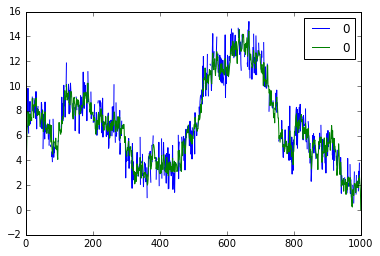

In [16]:
pd.concat([pd.DataFrame(kf3['y'])[0],pd.DataFrame(kf3['yhat'])[0],], axis=1).plot()

In [17]:
pd.concat([pd.DataFrame(kf3['yhat'])[0], kf1.yhat[0]],axis=1).plot()

NameError: name 'kf1' is not defined

In [ ]:
kf1 = KFPedro(y=nny,
              Z=Z,
              H=H,
              T=T,
              Q=Q,
              a1=pd.DataFrame(np.array([0.0,0.0]).reshape(m,1)),
              P1=pd.DataFrame(np.diag(np.array([1.0,1.0]))),
              R=R,
             nStates=2)


kf1.runFilter()
kf1.likelihood()

In [ ]:
kf1.ll